# 01. 예측모델 실습_자전거

예측 모델의 정확도를 높이기 위해 어떠한 방법을 사용하는지 공부한 내용입니다.

* **분석데이터**:
  https://www.kaggle.com/c/bike-sharing-demand

## Step1. LinearRegressor를 사용하여 분류기 만들기

### 데이터 클렌징 및 가공

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('./dataset/bike_sharing_demand_train.csv')

**Data Fields**

- datetime - 대여날짜 및 시간 
- season - 계절 (1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울 ) 
- holiday - 휴일 
- workingday - 주말과 휴일을 제외한 날 (평일) 
- weather - 날씨 * 1: 맑음, 대체로 흐림, 일부 흐림 * 2: 안개 + 흐림, 안개 + 깨진 구름, 안개 + 구름이 거의 없음, 안개 * 3: 가벼운 눈, 가벼운 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름 * 4: 폭우 + 얼음 팔레트 + 뇌우 + 안개, 눈 + 안개 
- temp - 섭씨 온도 
- atemp - 체감 온도 
- humidity - 상대 습도 
- windspeed - 풍속 
- casual - 미등록 사용자의 대여 횟수 
- registered - 등록된 사용자의 대여 횟수 
- count - 총 대여수

### [1] 분석할 데이터가 몇 개의 feature, 몇 개의 데이터로 구성되어 있는지 확인하기

In [2]:
# bike_df.shape
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### [2] bike_df의 데이터 중 숫자가 아닌 데이터가 포함된 필드 확인하기

In [3]:
# bike_df.isna().sum()
bike_df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

### [3]'datetime'에 있는 값을 'year', 'month', 'day', 'hour' 필드에 파싱하여 넣기
예)
2011-01-01 00:00:00 -> 2011	1	1	0

python의 'datetime64' 포맷을 활용

In [4]:
bike_df['datetime'] = bike_df['datetime'].astype('datetime64')     # 날짜형으로 형 변환
bike_df['year'] = bike_df['datetime'].dt.year
bike_df['month'] = bike_df['datetime'].dt.month
bike_df['day'] = bike_df['datetime'].dt.day
bike_df['hour'] = bike_df['datetime'].dt.hour
bike_df['minute'] = bike_df['datetime'].dt.minute
bike_df['second'] = bike_df['datetime'].dt.second
bike_df.head(2)

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   

   humidity  windspeed  casual  registered  count  year  month  day  hour  \
0        81        0.0       3          13     16  2011      1    1     0   
1        80        0.0       8          32     40  2011      1    1     1   

   minute  second  
0       0       0  
1       0       0

### [4] 각 데이터 필드의 값을 확인하시고, 불필요한 필드는 제거하기

dataframe의 drop() 사용

In [5]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

# del 같은거 써도 된다!

In [6]:
bike_df.head(1)

season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0       1        0           0        1  9.84  14.395        81        0.0   

   count  year  month  day  hour  minute  second  
0     16  2011      1    1     0       0       0

In [7]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   count       10886 non-null  int64  
 9   year        10886 non-null  int64  
 10  month       10886 non-null  int64  
 11  day         10886 non-null  int64  
 12  hour        10886 non-null  int64  
 13  minute      10886 non-null  int64  
 14  second      10886 non-null  int64  
dtypes: float64(3), int64(12)
memory usage: 1.2 MB


### [5] 모델을 만들기 위해 train set과 test set으로 분리하기
 1) 종속변수y 에 해당하는 값을 Y로 할당    
 2) 독립변수x 에 해당하는 값을 X로 할당  
 3) train_test_split 함수를 사용해서 분리(train:test = 7:3, random_state=0)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


y = bike_df['count']
X = bike_df.drop(['count'],axis=1,inplace=False)


# 학습용 데이터와 테스트용 데이터로 나눔
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state=1)
# 30%만 테스트로 쓰겠습니다!
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

7620
3266
7620
3266


### [6] LinearRegression을 사용하여 예측하는 모델을 학습시키기.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train ,y_train )

LinearRegression()

### [7] 모델을 사용하여 테스트 셋으로 분리한 값(X_test)의 예측값을 구하기

In [10]:
y_preds = lr.predict(X_test)

print('bias:',lr.intercept_)
print('weight:', np.round(lr.coef_, 1))
print(len(y_preds))

bias: -158986.65550202678
weight: [-10.2 -18.4  -0.8  -5.1   1.4   4.8  -2.    0.6  79.1  10.9   0.4   7.9
   0.    0. ]
3266


In [11]:
y_preds

array([179.05103681,  66.45224683, 380.80841321, ..., 132.45612664,
       122.07192998, 291.92058159])

In [12]:
bike_df.head(2)

season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0       1        0           0        1  9.84  14.395        81        0.0   
1       1        0           0        1  9.02  13.635        80        0.0   

   count  year  month  day  hour  minute  second  
0     16  2011      1    1     0       0       0  
1     40  2011      1    1     1       0       0

### [8] 모델의 정확도를 측정하기 
이 대회에서 정확도 평가는 RMSLE(Root Mean Squared Log Error)입니다. RMSLE는 아래 함수를 사용

In [13]:
def rmsle(y, pred):
    log_y = np.log1p(y)             
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    print('RMSLE: {0:.4f}'.format(rmsle))
    return rmsle
rmsle(y_test, y_preds)

RMSLE: 1.1447


1.144665741395989

## Step2. 모델 성능 개선하기

### [1] 예측값과 실제값의 차이가 가장 많이 나는 데이터 5개 출력

In [14]:
y_test

3709     308
6741      14
9848     539
1410     143
10672      1
        ... 
9192     123
6257      73
5829       2
10360     49
10253    382
Name: count, Length: 3266, dtype: int64

In [15]:
def get_top5_error_data(y_test, pred):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    # 예측값(pred)을 새로운 컬럼에 넣기
    result_df['predicted_count']= np.round(pred)
    # 실제값과 예측값과의 차이를 diff에 넣기
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:5])

get_top5_error_data(y_test, y_preds)

      real_count  predicted_count   diff
1950         809            191.0  618.0
1451         948            360.0  588.0
76           917            336.0  581.0
1302         970            410.0  560.0
1551         798            241.0  557.0


### [2] Y값 분포 시각화하기

히스토그램 사용하기

<AxesSubplot:>

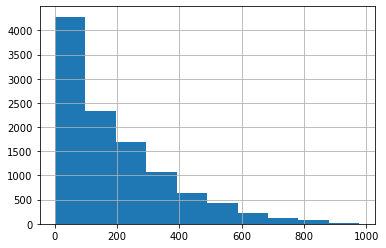

In [16]:
y.hist()

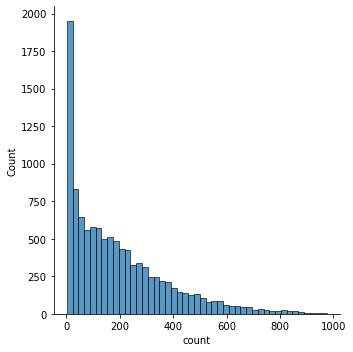

In [17]:
import seaborn as sns
sns.displot(y)                      
# y가 count, x가 적게빌린날, 많이 빌린날
# 적게 빌린 날이 많고, 많이 빌린날은 별로 없음 

### [3] Y의 로그값 분포 시각화하기
 
로그변환: numpy의 log1p() 함수

In [18]:
# 기존 y는 한쪽으로 치우친 형태의 그래프였음
# y의 로그 연산을 수행해서 정규분포의 형태로 데이터를 변환
# 로그연산의 장점: 지수 연산을 사용해서 다시 원본 데이터로 변환하기 유리함

<AxesSubplot:>

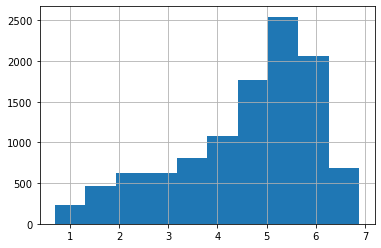

In [19]:
y_log = np.log1p(y)              
# scale를 이용해서 정규화하지말고, log를 이용해서 정규화하는게 더 정확하다는 연구 결과때문,,
# 선형회귀는 정규화해서 하라는 말이 있어서, 정규화하려고 함!
# 나중에 exp해서 실제값으로 복원도 편함!
y_log.hist()

### [4] Y의 로그값을 사용하여 모델 만들어보기

* 모델 학습, 예측, 평가는 get_model_predict()를 이용하였음

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=1)

In [21]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        # 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
        y_test = np.expm1(y_test)
        # 예측 값 역시 Log 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    rmsle(y_test, pred)

In [22]:
#[4]를 해결하기 위한 코드
lr_model_with_log = LinearRegression()

get_model_predict(lr_model_with_log,X_train, X_test, y_train, y_test, is_expm1=True )


### LinearRegression ###
RMSLE: 1.0114


### [5] 선형회귀모델에서 가장 영향을 많이 주는 종속변수 알아보기
아래 함수를 사용

In [23]:
def plotFeatureList(model, X):
    coef = pd.Series(model.coef_, index=X.columns)  
    # model.coef_ 하면 weight 값을 출력하게 됨, y= wx+b  여기서 w 값을 출력함, w가 칼수록 x가 중요함 
    coef_sort = coef.sort_values(ascending=False)
    sns.barplot(x=coef_sort.values, y=coef_sort.index)

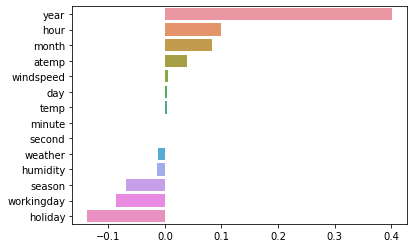

In [24]:
plotFeatureList(lr_model_with_log, X)

# Year가 굉장히 중요한 변수라고 말하는 중
# 근데 실제로 year가 중요하지 않으니까, 뭔가 전처리가 더 필요하고, year가 2개밖에 안되니까 카테고리 하자

### [6] 수치형 데이터 중 카테고리형 데이터 One Hot Encoding 하기

In [25]:
#[6]을 해결하기 위한 코드
# 크기를 가지고 있는 애들을 없애고, 그냥 데이터를 구분하려고 원 핫 인코딩 하는 것
# 크기는 중요하지 않고 그냥 구분하고 싶어!, year가 너무 크잖아

# 이때 이용하는게 판다스의 get_dummies

X_features_ohe = pd.get_dummies(X, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])
X_features_ohe
# year은 총 2개이고, 2011년에 해당하는 데이터이면 2011에 1 나머지는 0
# month는 총 12개이고 1월달에 해당하면 1월에 1 나머지는 다 0
# 크기는 없어지고 구분만 하려고 

temp   atemp  humidity  windspeed  minute  second  year_2011  \
0       9.84  14.395        81     0.0000       0       0          1   
1       9.02  13.635        80     0.0000       0       0          1   
2       9.02  13.635        80     0.0000       0       0          1   
3       9.84  14.395        75     0.0000       0       0          1   
4       9.84  14.395        75     0.0000       0       0          1   
...      ...     ...       ...        ...     ...     ...        ...   
10881  15.58  19.695        50    26.0027       0       0          0   
10882  14.76  17.425        57    15.0013       0       0          0   
10883  13.94  15.910        61    15.0013       0       0          0   
10884  13.94  17.425        61     6.0032       0       0          0   
10885  13.12  16.665        66     8.9981       0       0          0   

       year_2012  month_1  month_2  ...  workingday_0  workingday_1  season_1  \
0              0        1        0  ...             1             0         1   
1              0        1        0  ...             1             0         1   
2              0        1        0  ...             1             0         1   
3              0        1        0  ...             1             0         1   
4              0        1        0  ...             1             0         1   
...          ...      ...      ...  ...           ...           ...       ...   
10881          1        0        0  ...             0             1         0   
10882          1        0        0  ...             0             1         0   
10883          1        0        0  ...             0             1         0   
10884          1        0        0  ...             0             1         0   
10885          1        0        0  ...             0             1         0   

       season_2  season_3  season_4  weather_1  weather_2  weather_3  \
0             0         0         0          1          0          0   
1             0         0         0          1          0          0   
2             0         0         0          1          0          0   
3             0         0         0          1          0          0   
4             0         0         0          1          0          0   
...         ...       ...       ...        ...        ...        ...   
10881         0         0         1          1          0          0   
10882         0         0         1          1          0          0   
10883         0         0         1          1          0          0   
10884         0         0         1          1          0          0   
10885         0         0         1          1          0          0   

       weather_4  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
10881          0  
10882          0  
10883          0  
10884          0  
10885          0  

[10886 rows x 75 columns]

### [7] One Hot Encoding 적용된 feature 데이터 세트 기반으로 학습/예측 

 * 데이터 분할
 * 학습: LinearRegression, RandomForestRegressor, GradientBoostingRegressor, XGBRegressor, LGBMRegressor
 * 예측
 * 평가

In [26]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [27]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_log, test_size=0.3, random_state=1)

# LinearRegression, 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=500)
gbm_model = GradientBoostingRegressor(n_estimators=500)
xgb_model = XGBRegressor(n_estimators=500)
lgbm_model = LGBMRegressor(n_estimators=500)

model_list = [lr_model, rf_model, gbm_model, xgb_model, lgbm_model]
for model in model_list:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)
    print(' ')

### LinearRegression ###
RMSLE: 0.5835
 
### RandomForestRegressor ###
RMSLE: 0.3440
 
### GradientBoostingRegressor ###
RMSLE: 0.3342
 
### XGBRegressor ###
RMSLE: 0.3376
 
### LGBMRegressor ###
RMSLE: 0.3102
 


## Step3. 개선

### test파일 불러오기

In [28]:
bike_test_df = pd.read_csv('test.csv')

In [29]:
bike_test_df

datetime  season  holiday  workingday  weather   temp  \
0     2011-01-20 00:00:00       1        0           1        1  10.66   
1     2011-01-20 01:00:00       1        0           1        1  10.66   
2     2011-01-20 02:00:00       1        0           1        1  10.66   
3     2011-01-20 03:00:00       1        0           1        1  10.66   
4     2011-01-20 04:00:00       1        0           1        1  10.66   
...                   ...     ...      ...         ...      ...    ...   
6488  2012-12-31 19:00:00       1        0           1        2  10.66   
6489  2012-12-31 20:00:00       1        0           1        2  10.66   
6490  2012-12-31 21:00:00       1        0           1        1  10.66   
6491  2012-12-31 22:00:00       1        0           1        1  10.66   
6492  2012-12-31 23:00:00       1        0           1        1  10.66   

       atemp  humidity  windspeed  
0     11.365        56    26.0027  
1     13.635        56     0.0000  
2     13.635        56     0.0000  
3     12.880        56    11.0014  
4     12.880        56    11.0014  
...      ...       ...        ...  
6488  12.880        60    11.0014  
6489  12.880        60    11.0014  
6490  12.880        60    11.0014  
6491  13.635        56     8.9981  
6492  13.635        65     8.9981  

[6493 rows x 9 columns]

In [30]:
bike_test_df['datetime'] = bike_test_df['datetime'].astype('datetime64')     # 날짜형으로 형 변환
bike_test_df['year'] = bike_test_df['datetime'].dt.year
bike_test_df['month'] = bike_test_df['datetime'].dt.month
bike_test_df['day'] = bike_test_df['datetime'].dt.day
bike_test_df['hour'] = bike_test_df['datetime'].dt.hour
bike_test_df['minute'] = bike_test_df['datetime'].dt.minute
bike_test_df['second'] = bike_test_df['datetime'].dt.second


In [31]:
bike_df.head(2)

season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0       1        0           0        1  9.84  14.395        81        0.0   
1       1        0           0        1  9.02  13.635        80        0.0   

   count  year  month  day  hour  minute  second  
0     16  2011      1    1     0       0       0  
1     40  2011      1    1     1       0       0

In [32]:
drop_columns = ['datetime']
bike_test_df.drop(drop_columns, axis=1, inplace=True)

In [33]:
bike_test_df.head()

season  holiday  workingday  weather   temp   atemp  humidity  windspeed  \
0       1        0           1        1  10.66  11.365        56    26.0027   
1       1        0           1        1  10.66  13.635        56     0.0000   
2       1        0           1        1  10.66  13.635        56     0.0000   
3       1        0           1        1  10.66  12.880        56    11.0014   
4       1        0           1        1  10.66  12.880        56    11.0014   

   year  month  day  hour  minute  second  
0  2011      1   20     0       0       0  
1  2011      1   20     1       0       0  
2  2011      1   20     2       0       0  
3  2011      1   20     3       0       0  
4  2011      1   20     4       0       0

In [34]:
X = bike_test_df

## [MinMaxScaler]

In [35]:
bike_df.head()

season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0       1        0           0        1  9.84  14.395        81        0.0   
1       1        0           0        1  9.02  13.635        80        0.0   
2       1        0           0        1  9.02  13.635        80        0.0   
3       1        0           0        1  9.84  14.395        75        0.0   
4       1        0           0        1  9.84  14.395        75        0.0   

   count  year  month  day  hour  minute  second  
0     16  2011      1    1     0       0       0  
1     40  2011      1    1     1       0       0  
2     32  2011      1    1     2       0       0  
3     13  2011      1    1     3       0       0  
4      1  2011      1    1     4       0       0

In [36]:
bike_df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'year', 'month', 'day', 'hour',
       'minute', 'second'],
      dtype='object')

In [37]:
from sklearn.preprocessing import MinMaxScaler
# MinMaxScaler  각각의 min값과 max 값을 0, 1로 바꿔준다


scaler = MinMaxScaler()
scaler.fit(bike_df)
scaled_array = scaler.transform(bike_df)

scaled_df = pd.DataFrame(data=scaled_array)
scaled_df.columns = bike_df.columns
scaled_df

season  holiday  workingday  weather      temp     atemp  humidity  \
0         0.0      0.0         0.0      0.0  0.224490  0.305068      0.81   
1         0.0      0.0         0.0      0.0  0.204082  0.288064      0.80   
2         0.0      0.0         0.0      0.0  0.204082  0.288064      0.80   
3         0.0      0.0         0.0      0.0  0.224490  0.305068      0.75   
4         0.0      0.0         0.0      0.0  0.224490  0.305068      0.75   
...       ...      ...         ...      ...       ...       ...       ...   
10881     1.0      0.0         1.0      0.0  0.367347  0.423649      0.50   
10882     1.0      0.0         1.0      0.0  0.346939  0.372860      0.57   
10883     1.0      0.0         1.0      0.0  0.326531  0.338964      0.61   
10884     1.0      0.0         1.0      0.0  0.326531  0.372860      0.61   
10885     1.0      0.0         1.0      0.0  0.306122  0.355856      0.66   

       windspeed     count  year  month  day      hour  minute  second  
0       0.000000  0.015369   0.0    0.0  0.0  0.000000     0.0     0.0  
1       0.000000  0.039959   0.0    0.0  0.0  0.043478     0.0     0.0  
2       0.000000  0.031762   0.0    0.0  0.0  0.086957     0.0     0.0  
3       0.000000  0.012295   0.0    0.0  0.0  0.130435     0.0     0.0  
4       0.000000  0.000000   0.0    0.0  0.0  0.173913     0.0     0.0  
...          ...       ...   ...    ...  ...       ...     ...     ...  
10881   0.456213  0.343238   1.0    1.0  1.0  0.826087     0.0     0.0  
10882   0.263195  0.245902   1.0    1.0  1.0  0.869565     0.0     0.0  
10883   0.263195  0.171107   1.0    1.0  1.0  0.913043     0.0     0.0  
10884   0.105325  0.131148   1.0    1.0  1.0  0.956522     0.0     0.0  
10885   0.157870  0.089139   1.0    1.0  1.0  1.000000     0.0     0.0  

[10886 rows x 15 columns]

In [38]:
y_train = scaled_df['count']
X_train = scaled_df.drop(['count'],axis=1,inplace=False)


# 학습용 데이터와 테스트용 데이터로 나눔
# X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state=1)
# # 30%만 테스트로 쓰겠습니다!
X_train.head()

season  holiday  workingday  weather      temp     atemp  humidity  \
0     0.0      0.0         0.0      0.0  0.224490  0.305068      0.81   
1     0.0      0.0         0.0      0.0  0.204082  0.288064      0.80   
2     0.0      0.0         0.0      0.0  0.204082  0.288064      0.80   
3     0.0      0.0         0.0      0.0  0.224490  0.305068      0.75   
4     0.0      0.0         0.0      0.0  0.224490  0.305068      0.75   

   windspeed  year  month  day      hour  minute  second  
0        0.0   0.0    0.0  0.0  0.000000     0.0     0.0  
1        0.0   0.0    0.0  0.0  0.043478     0.0     0.0  
2        0.0   0.0    0.0  0.0  0.086957     0.0     0.0  
3        0.0   0.0    0.0  0.0  0.130435     0.0     0.0  
4        0.0   0.0    0.0  0.0  0.173913     0.0     0.0

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train ,y_train )

LinearRegression()

In [40]:
y_preds = lr.predict(X)

print('bias:',lr.intercept_)
print('weight:', np.round(lr.coef_, 1))
y_preds

bias: -0.006001959969635179
weight: [-0.  -0.   0.  -0.   0.1  0.2 -0.2  0.   0.1  0.1  0.   0.2  0.   0. ]


array([163.11656033, 162.86717855, 163.05047355, ..., 167.31789699,
       168.42719355, 166.73137779])

In [41]:
submission = pd.read_csv('sampleSubmission.csv')
submission.head()

datetime  count
0  2011-01-20 00:00:00      0
1  2011-01-20 01:00:00      0
2  2011-01-20 02:00:00      0
3  2011-01-20 03:00:00      0
4  2011-01-20 04:00:00      0

In [42]:
submission['count'] = y_preds
submission.head()

datetime       count
0  2011-01-20 00:00:00  163.116560
1  2011-01-20 01:00:00  162.867179
2  2011-01-20 02:00:00  163.050474
3  2011-01-20 03:00:00  163.460796
4  2011-01-20 04:00:00  163.644091

In [43]:
submission.to_csv('RandomForest_casual_registered.csv', index=False)

## 아웃라이어 빼보기(전처리)

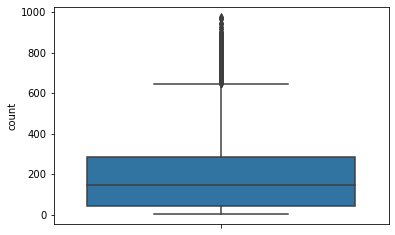

In [44]:
sns.boxplot(data=bike_df, y='count')
plt.show()

In [45]:
bike_df.shape

(10886, 15)

In [46]:
Q1 = bike_df['count'].quantile(0.25)
Q3 = bike_df['count'].quantile(0.75)
IQR = Q3-Q1
bike_df = bike_df[((bike_df['count'])<(Q1 - 1.5*IQR))|((bike_df['count'])<(Q1 + 1.5*IQR))]
bike_df.shape

(9476, 15)

In [47]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9476 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      9476 non-null   int64  
 1   holiday     9476 non-null   int64  
 2   workingday  9476 non-null   int64  
 3   weather     9476 non-null   int64  
 4   temp        9476 non-null   float64
 5   atemp       9476 non-null   float64
 6   humidity    9476 non-null   int64  
 7   windspeed   9476 non-null   float64
 8   count       9476 non-null   int64  
 9   year        9476 non-null   int64  
 10  month       9476 non-null   int64  
 11  day         9476 non-null   int64  
 12  hour        9476 non-null   int64  
 13  minute      9476 non-null   int64  
 14  second      9476 non-null   int64  
dtypes: float64(3), int64(12)
memory usage: 1.2 MB


#### MaxABbsScaler

In [48]:
from sklearn.preprocessing import MaxAbsScaler
maxAbsScaler = MaxAbsScaler()
maxAbsScaler.fit(bike_df)

bike_df_maxAbsScaled = maxAbsScaler.transform(bike_df)

scaled_bike_df = pd.DataFrame(data=bike_df_maxAbsScaled)
scaled_bike_df.columns = bike_df.columns
scaled_bike_df

season  holiday  workingday  weather  temp     atemp  humidity  \
0       0.25      0.0         0.0     0.25  0.24  0.316687      0.81   
1       0.25      0.0         0.0     0.25  0.22  0.299967      0.80   
2       0.25      0.0         0.0     0.25  0.22  0.299967      0.80   
3       0.25      0.0         0.0     0.25  0.24  0.316687      0.75   
4       0.25      0.0         0.0     0.25  0.24  0.316687      0.75   
...      ...      ...         ...      ...   ...       ...       ...   
9471    1.00      0.0         1.0     0.25  0.38  0.433286      0.50   
9472    1.00      0.0         1.0     0.25  0.36  0.383346      0.57   
9473    1.00      0.0         1.0     0.25  0.34  0.350016      0.61   
9474    1.00      0.0         1.0     0.25  0.34  0.383346      0.61   
9475    1.00      0.0         1.0     0.25  0.32  0.366626      0.66   

      windspeed     count      year     month       day      hour  minute  \
0      0.000000  0.039604  0.999503  0.083333  0.052632  0.000000     0.0   
1      0.000000  0.099010  0.999503  0.083333  0.052632  0.043478     0.0   
2      0.000000  0.079208  0.999503  0.083333  0.052632  0.086957     0.0   
3      0.000000  0.032178  0.999503  0.083333  0.052632  0.130435     0.0   
4      0.000000  0.002475  0.999503  0.083333  0.052632  0.173913     0.0   
...         ...       ...       ...       ...       ...       ...     ...   
9471   0.456213  0.831683  1.000000  1.000000  1.000000  0.826087     0.0   
9472   0.263195  0.596535  1.000000  1.000000  1.000000  0.869565     0.0   
9473   0.263195  0.415842  1.000000  1.000000  1.000000  0.913043     0.0   
9474   0.105325  0.319307  1.000000  1.000000  1.000000  0.956522     0.0   
9475   0.157870  0.217822  1.000000  1.000000  1.000000  1.000000     0.0   

      second  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
...      ...  
9471     0.0  
9472     0.0  
9473     0.0  
9474     0.0  
9475     0.0  

[9476 rows x 15 columns]

In [49]:
y = scaled_bike_df['count']
X = scaled_bike_df.drop(['count'],axis=1,inplace=False)


# 학습용 데이터와 테스트용 데이터로 나눔
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state=1)
# 30%만 테스트로 쓰겠습니다!
X_train.head()

season  holiday  workingday  weather  temp     atemp  humidity  \
1310    0.25      0.0         0.0     0.25  0.46  0.499945      0.36   
2726    0.75      0.0         1.0     0.25  0.66  0.649984      0.89   
6098    0.25      0.0         1.0     0.25  0.34  0.333297      0.46   
3338    0.75      0.0         1.0     0.25  0.76  0.749973      0.48   
3219    0.75      0.0         1.0     0.25  0.64  0.683313      0.61   

      windspeed      year     month       day      hour  minute  second  
1310   0.526390  0.999503  0.250000  1.000000  0.478261     0.0     0.0  
2726   0.228047  0.999503  0.583333  0.368421  0.086957     0.0     0.0  
6098   0.350888  1.000000  0.250000  0.315789  0.826087     0.0     0.0  
3338   0.350888  0.999503  0.666667  0.842105  0.565217     0.0     0.0  
3219   0.228047  0.999503  0.666667  0.578947  0.217391     0.0     0.0

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train ,y_train )

LinearRegression()

In [51]:
y_preds = lr.predict(X_test)

print('bias:',lr.intercept_)
print('weight:', np.round(lr.coef_, 1))
y_preds

bias: -158.3728331589094
weight: [-1.000e-01 -0.000e+00 -0.000e+00 -0.000e+00  1.000e-01  3.000e-01
 -4.000e-01  0.000e+00  1.585e+02  2.000e-01  0.000e+00  4.000e-01
  0.000e+00  0.000e+00]


array([0.25382665, 0.19241691, 0.13435484, ..., 0.3723721 , 0.62558202,
       0.48906417])

In [52]:
submission

datetime       count
0     2011-01-20 00:00:00  163.116560
1     2011-01-20 01:00:00  162.867179
2     2011-01-20 02:00:00  163.050474
3     2011-01-20 03:00:00  163.460796
4     2011-01-20 04:00:00  163.644091
...                   ...         ...
6488  2012-12-31 19:00:00  166.936279
6489  2012-12-31 20:00:00  167.119574
6490  2012-12-31 21:00:00  167.317897
6491  2012-12-31 22:00:00  168.427194
6492  2012-12-31 23:00:00  166.731378

[6493 rows x 2 columns]

In [53]:
def rmsle(y, pred):
    log_y = np.log1p(y)             
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    print('RMSLE: {0:.4f}'.format(rmsle))
    return rmsle
rmsle(y_test, y_preds)

RMSLE: 0.1549


0.1549368106374312

In [54]:
model_list = [lr_model, rf_model, gbm_model, xgb_model, lgbm_model]

for model in model_list:
    # 학습
    model.fit(X_train , y_train)

    # 예측
    pred = model.predict(X_test)
    
    # 평가
    res =  rmsle(y_test, pred)
    
    model_name = model.__class__.__name__
    print('{0} 오차: {1:.4f}\n'.format(model_name, res)) 

RMSLE: 0.1549
LinearRegression 오차: 0.1549

RMSLE: 0.0605
RandomForestRegressor 오차: 0.0605

RMSLE: 0.0631
GradientBoostingRegressor 오차: 0.0631

RMSLE: 0.0569
XGBRegressor 오차: 0.0569

RMSLE: 0.0523
LGBMRegressor 오차: 0.0523



#### 하이퍼 파라미터 찾아보기

In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
# 랜덤포레스트 파라미터 찾기 

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}
grid_rf = GridSearchCV(rf_model, param_grid=params, cv=3)
grid_rf.fit(X_train, y_train)
print('최적 하이 파라미터:', grid_rf.best_params_)

최적 하이 파라미터: {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}


In [57]:
estimator = grid_rf.best_estimator_  # grid_rf.best_estimator_ 이 애가 최적에 파라미터가 적용된 모델
estimator

RandomForestRegressor(max_depth=12, min_samples_leaf=8, min_samples_split=8)

In [58]:
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
   
    print('###',model.__class__.__name__,'###')
    rmsle(y_test, pred)

In [59]:
get_model_predict(estimator, X_train, X_test, y_train, y_test)

### RandomForestRegressor ###
RMSLE: 0.0667


In [60]:
y_preds = estimator.predict(X)

y_preds

array([0.07521956, 0.0711671 , 0.05741384, ..., 0.42402141, 0.38288063,
       0.27163086])